## Using SPDR S&amp;P 500 ETF Trust, SPDR Gold Shares and iShares 20+ Year Treasury Bond ETF, backtest the performance of a risk parity portfolio using VBA or Python.

#### https://portfolioslab.com/portfolio/ray-dalio-all-weather
Ray Dalio is one of the man I look up to when it comes to creating a risk parity portfolio. From the website. I adopted the allocations and match the 3 assets stated. To create a visual comparison, I also created 3 other portfolios namely the conventional 60-40 stock to bond portfolio, 100% equity and 100% bond.

#### https://finance.yahoo.com/news/often-rebalance-portfolio-185622641.html#:~:text=There's%20no%20single%20answer%20for,fits%20your%20overall%20investing%20style.
For rebalancing, I have adopted from this website which rebalancing occurs whenever the sum of the differences between the stipulated allocation and the actual allocation is over 10%.

For prices of each asset, I will be using yfinance library.

#### Assumptions
- no constant cashflows
- no fees
- no leverages
- reinvestment of dividends are ignored

#### Limitations
- a risk parity portfolio is made using Ray Dalio's formula instead of using stdev of asset to come out with a equal risk allocation portfolio
- backtest begins in 2005 as GLD's inception date is end of 2004


#### Importing of libraries

In [45]:
# LIBRARIES
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statistics
from dateutil.relativedelta import relativedelta
from datetime import datetime
from datetime import timedelta
from matplotlib.pyplot import figure

#### Creation of different portfolios

In [2]:
# ALL WEATHER PORTFOLIO - RAY DALIO
portfolio1 = {'SPY': 0.3, 'TLT': 0.55, 'GLD': 0.15}


# CONVENTIONAL 60-40 PORTFOLIO
portfolio2 = {'SPY': 0.6, 'TLT': 0.4}


# 100% EQUITY
portfolio3 = {'SPY': 1}


# 100% BOND
portfolio4 = {'TLT': 1}


portfolios = {'all weather': portfolio1, '60-40': portfolio2, '100% equity': portfolio3, '100% bond': portfolio4}

#### Visual Representation of each portfolio

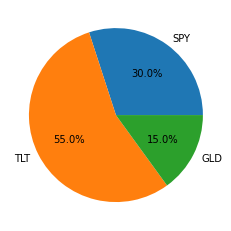

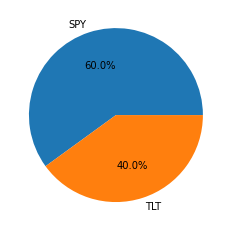

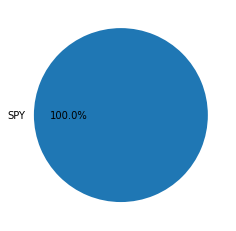

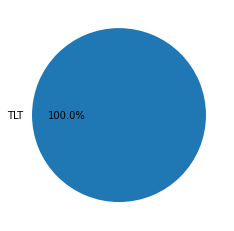

In [3]:
# PIE REPRESENTATION OF PORTFOLIO ALLOCATION
def generate_pie(portfolio):
    tickers = []
    allocations = []
    for ticker, allocation in portfolio.items():
        tickers.append(ticker)
        allocations.append(allocation)
    
    plt.pie(allocations, labels = tickers, autopct='%1.1f%%')
    
def generate_pies(portfolios):
    i = 0
    for portfolio_name, portfolio in portfolios.items():
        plt.figure(i)
        generate_pie(portfolio)
        i+=1
        
    plt.show()
    
generate_pies(portfolios)

#### Display all tickers

In [4]:
## LIST ALL POSSIBLE TICKERS IN A PORTFOLIO
def list_of_tickers(portfolio):
    
    tickers = []
    
    for ticker, allocation in portfolio.items():
        if ticker not in tickers:
            tickers.append(ticker)
                
    return tickers         

tickers = list_of_tickers(portfolio1)
print("all tickers:", tickers)

all tickers: ['SPY', 'TLT', 'GLD']


#### Get prices for each asset

In [39]:
## DISPLAY ADJUSTED CLOSE PRICES FOR ALL TICKERS
def get_prices(portfolio, start_date, end_date, interval):
    
    tickers = list_of_tickers(portfolio)
    
    if len(tickers) > 1:
        first = True
        for ticker in tickers:
            df = yf.download(ticker, start_date, end_date, interval = interval, threads= False, progress=False)
            df = df.reset_index()
            df = df[['Date','Adj Close']]
            df = df.rename(columns={'Adj Close': ticker}) 

            if first:
                result = df
                first = False
            else:
                result = pd.merge(result, df, on="Date")

    
    else:
        ticker = tickers[0]
        df = yf.download(ticker, start_date, end_date, interval = interval, threads= False, progress=False)
        df = df.reset_index()
        df = df[['Date','Adj Close']]
        df.dropna(subset = ["Adj Close"], inplace=True)
        df = df.rename(columns={'Adj Close': ticker})
        result = df
        
    result['Year'] = result['Date'].dt.year
    result['Month'] = result['Date'].dt.month
    result['Day'] = result['Date'].dt.day  
    
    return result

adj_close_prices = get_prices(portfolio1, '2005-01-01', '2022-01-01', '3mo')
adj_close_prices

,Date,SPY,TLT,GLD,Year,Month,Day
0,2004-12-01,86.101540,52.155502,43.529999,2004,12,1
1,2005-03-01,85.683540,55.686367,41.650002,2005,3,1
2,2005-06-01,88.251991,56.855747,43.400002,2005,6,1
3,2005-09-01,90.653831,53.888351,49.099998,2005,9,1
4,2005-12-01,93.086891,55.348812,56.070000,2005,12,1
...,...,...,...,...,...,...,...
64,2020-12-01,373.763336,140.460083,161.809998,2020,12,1
65,2021-03-01,414.514618,136.305283,178.380005,2021,3,1
66,2021-06-01,447.079498,147.127487,169.690002,2021,6,1
67,2021-09-01,452.515411,150.450455,165.500000,2021,9,1


#### Key in parameters for backtesting

In [6]:
# INPUT PARAMETERS FOR BACK TEST
interval = '3mo' #1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
start_date = '2005-02-01' #YYYY-MM-DD
end_date = '2022-01-01'#YYYY-MM-DD
initial_amount = 1000 

#### Function for backtest

In [7]:
def backtest(portfolio, start_date, end_date, interval, initial_amount, rebalance):
    
    tickers = list_of_tickers(portfolio)
    daily_prices = get_prices(portfolio, start_date, end_date, interval)
    reference_price = daily_prices.iloc[0]
    
    
    navs = []
    dates = []
    years = []
    months = []
    rebalance_day = []
    
    for each_day in range(len(daily_prices)):
    
        date = daily_prices.iloc[each_day]['Date']
        year = daily_prices.iloc[each_day]['Year']
        month = daily_prices.iloc[each_day]['Month']
        dates.append(date)
        months.append(month)
        years.append(year)
        
        #record prices of tickers for each new day
        price = {}
        for ticker in tickers:
            price[ticker] = daily_prices.iloc[each_day][ticker]
        
        #record value of each assets for each new day
        respective_nav = {}
        for ticker, allocation in portfolio.items():
            respective_nav[ticker] = initial_amount * allocation / reference_price[ticker] * price[ticker]
            total = sum(respective_nav.values())
            
        #record overall net asset value into list
        navs.append(total)    

        #record current weightage for each asset
        weightages = {}
        for asset, value in respective_nav.items():
            weightage = value / total
            weightages[asset] = weightage
        
        if rebalance:
            #store the sum of the differences in allocation
            sum_of_diff = 0
            for ticker, allocation in portfolio.items():
                sum_of_diff += abs(weightages[ticker] - allocation)

            #if sum of differences is more than 10%, rebalancing is needed
            if sum_of_diff > 0.1:
                initial_amount = total
                reference_price = daily_prices.iloc[each_day]
                rebalance_day.append("YES")
            else:
                rebalance_day.append("NO")
        else:
            rebalance_day.append("NO")
            
             
    df = pd.DataFrame({'Date' : dates, 'Year' : years, 'Month' : months, 'NAV' : navs, 'Rebalance' : rebalance_day})
    df['pct_change'] = (df['NAV'] / df['NAV'].shift(1) - 1)
    
    return df

p1a = backtest(portfolio1, start_date, end_date, interval, initial_amount, True)
p1a.loc[p1a['Rebalance'] == 'YES']

,Date,Year,Month,NAV,Rebalance,pct_change
7,2006-10-01,2006,10,1180.088961,YES,0.031649
14,2008-07-01,2008,7,1293.180191,YES,-0.014087
15,2008-10-01,2008,10,1405.310705,YES,0.086709
17,2009-04-01,2009,4,1282.688845,YES,-0.004554
19,2009-10-01,2009,10,1381.033906,YES,-0.010522
26,2011-07-01,2011,7,1837.605425,YES,0.126393
28,2012-01-01,2012,1,1934.904716,YES,0.016204
34,2013-07-01,2013,7,1989.944899,YES,0.009982
48,2017-01-01,2017,1,2544.604938,YES,0.041732
54,2018-07-01,2018,7,2739.536559,YES,0.002216


#### Display performance of portfolios

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Performance of different portfolios without auto rebalancing')

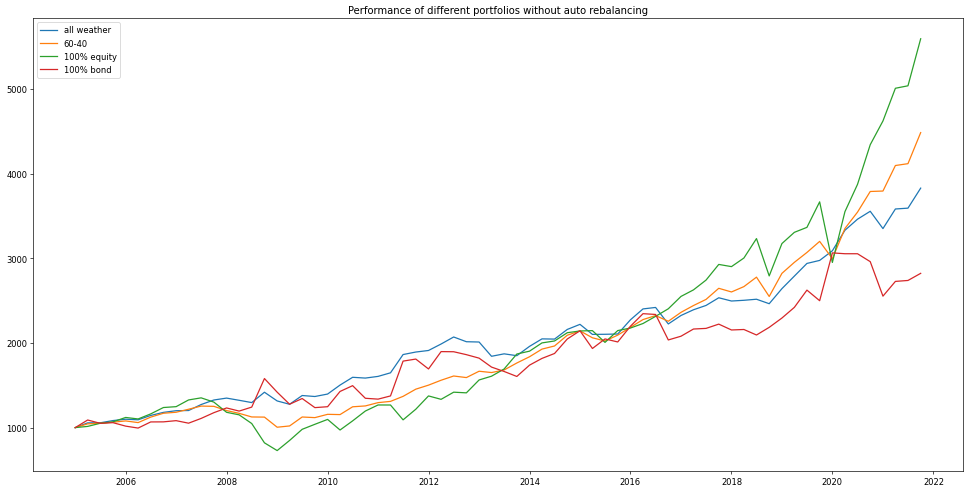

In [8]:
# CREATE BACKTESTS FOR ALL PORTFOLIOS WITH NO REBALANCE
dfs = {}
for portfolio_name, portfolio in portfolios.items():
    dfs[portfolio_name] = backtest(portfolio, start_date, end_date, interval, initial_amount, False)

# PLOT GRAPH
plt.figure(figsize=(20, 10), dpi=60)
for portfolio_name, df in dfs.items():
    plt.plot(df['Date'].tolist(), df['NAV'].tolist(), label= portfolio_name)
    
plt.legend()
plt.title(label='Performance of different portfolios without auto rebalancing')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Performance of different portfolios with auto rebalancing')

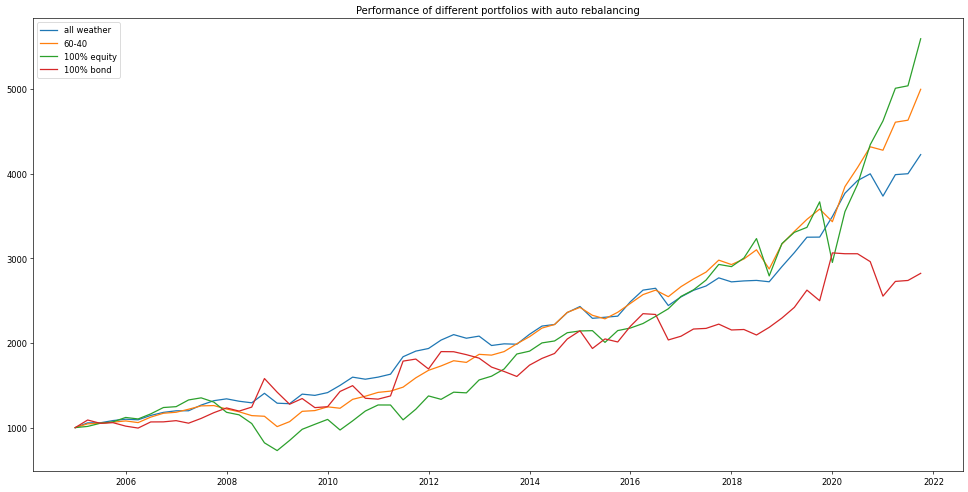

In [9]:
# CREATE BACKTESTS FOR ALL PORTFOLIOS WITH REBALANCE
dfs = {}
for portfolio_name, portfolio in portfolios.items():
    dfs[portfolio_name] = backtest(portfolio, start_date, end_date, interval, initial_amount, True)

# PLOT GRAPH
plt.figure(figsize=(20, 10), dpi=60)
for portfolio_name, df in dfs.items():
    plt.plot(df['Date'].tolist(), df['NAV'].tolist(), label= portfolio_name)
    
plt.legend()
plt.title(label='Performance of different portfolios with auto rebalancing')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Volatility of different portfolios with auto rebalancing')

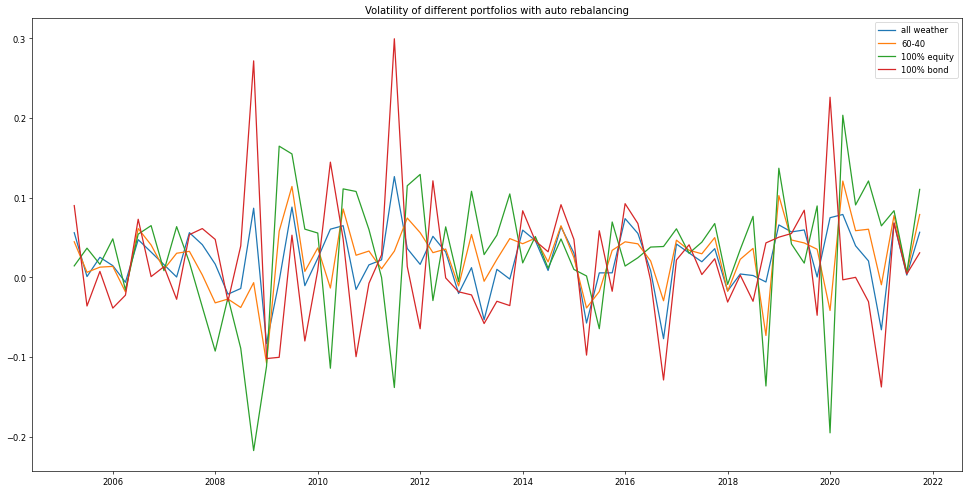

In [10]:
# CREATE BACKTESTS FOR ALL PORTFOLIOS WITH REBALANCE
dfs = {}
for portfolio_name, portfolio in portfolios.items():
    dfs[portfolio_name] = backtest(portfolio, start_date, end_date, interval, initial_amount, True)

# PLOT GRAPH
plt.figure(figsize=(20, 10), dpi=60)
for portfolio_name, df in dfs.items():
    plt.plot(df['Date'].tolist(), df['pct_change'].tolist(), label= portfolio_name)
    
plt.legend()
plt.title(label='Volatility of different portfolios with auto rebalancing')

Text(0.5, 1.0, 'Volatility of different portfolios with auto rebalancing')

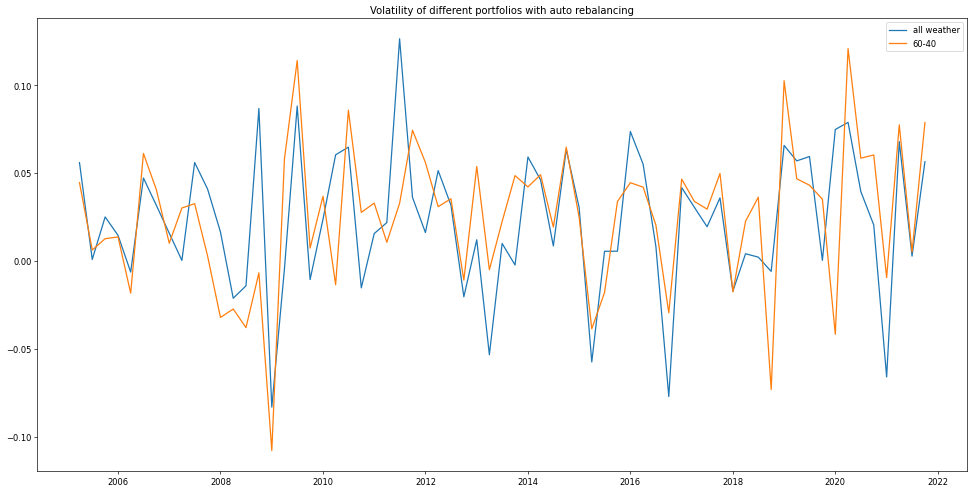

In [11]:
# CREATE BACKTESTS FOR FIRST TWO PORTFOLIOS WITH REBALANCE
dfs = {}

i = 0
for portfolio_name, portfolio in portfolios.items():
    dfs[portfolio_name] = backtest(portfolio, start_date, end_date, interval, initial_amount, True)
    i += 1
    if i > 1:
        break

# PLOT GRAPH
plt.figure(figsize=(20, 10), dpi=60)
for portfolio_name, df in dfs.items():
    plt.plot(df['Date'].tolist(), df['pct_change'].tolist(), label= portfolio_name)
    
plt.legend()
plt.title(label='Volatility of different portfolios with auto rebalancing')

Text(0.5, 1.0, 'Performance of all weather portfolio with and without auto rebalancing')

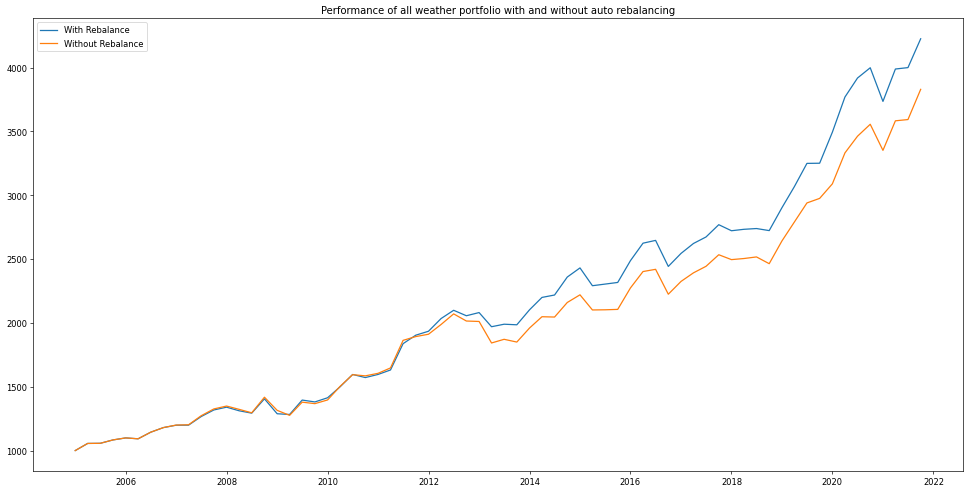

In [12]:
# CREATE BACKTESTS FOR PORTFOLIO1 WHERE ONE HAS REBALANCE ONE DOES NOT
p1a = backtest(portfolio1, start_date, end_date, interval, initial_amount, True)
p1b = backtest(portfolio1, start_date, end_date, interval, initial_amount, False)
p1a.loc[p1a['Rebalance'] == 'YES']

# PLOT GRAPH
plt.figure(figsize=(20, 10), dpi=60)
plt.plot(p1a['Date'].tolist(), p1a['NAV'].tolist(), label='With Rebalance')
plt.plot(p1b['Date'].tolist(), p1b['NAV'].tolist(), label='Without Rebalance')
plt.legend()
plt.title(label='Performance of all weather portfolio with and without auto rebalancing')

#### Numerical performance of portfolios

In [154]:
df = backtest(portfolio1, start_date, end_date, interval, initial_amount, True)

In [155]:
def cagr(df):
    
    ending_value = df.iloc[-1]['NAV']
    beginning_value = df.iloc[0]['NAV']
    
    num_of_days = (df.iloc[-1]['Date'] - df.iloc[0]['Date']).days
    num_of_years = num_of_days / 365

    c = (ending_value / beginning_value)**(1 / num_of_years) - 1
    
    return c

In [157]:
def stdev(df):
    
    s = statistics.stdev(df['pct_change'].tolist()[1:])
    
    return s

In [158]:
def best_year(df):
    
    df = df.groupby('Year').first()
    df["pct_change"] = (df['NAV'] / df['NAV'].shift(1) - 1)
    b = df['pct_change'].max()
    
    return b

In [159]:
def worst_year(df):
    
    df = df.groupby('Year').first()
    df["pct_change"] = (df['NAV'] / df['NAV'].shift(1) - 1)
    w = df['pct_change'].min()
    
    return w

In [167]:
def sharpe_ratio(df):
    
    rf_rate = yf.Ticker('^TNX').history().tail(1)['Close'].iloc[0] / 100
    sr = (cagr(df) - rf_rate) / stdev(df) 
    
    return sr

In [169]:
print(f"{'PORTFOLIO' : <15}{'CAGR' : <10}{'STDEV' : <10}{'BEST YEAR' : <12}{'WORST YEAR' : <13}{'MAX DRAWDOWN' : <15}{'SHARPE RATIO' : <15}")
print("---------------------------------------------------------------------------------------")
rebalance = True
for i in range(2):
    if rebalance:
        print("With Rebalancing")
    else:
        print("Without Rebalancing")
        
    for portfolio_name, portfolio in portfolios.items():
        df = backtest(portfolio, start_date, end_date, interval, initial_amount, rebalance)
        c = "{:.2%}".format(cagr(df))
        s = "{:.2%}".format(stdev(df))
        b = "{:.2%}".format(best_year(df))
        w = "{:.2%}".format(worst_year(df))
        d = "{:.2%}".format(worst_year(df))
        sr = "{:.2f}".format(sharpe_ratio(df))
        print(f"{portfolio_name : <15}{c : <10}{s : <10}{b: <12}{w: <13}{d:<15}{sr:<15}")
    
    print(" ")
    
    rebalance = False

PORTFOLIO      CAGR      STDEV     BEST YEAR   WORST YEAR   MAX DRAWDOWN   SHARPE RATIO   
---------------------------------------------------------------------------------------
With Rebalancing
all weather    8.98%     4.00%     21.20%      -3.84%       -3.84%         1.82           
60-40          10.08%    4.10%     24.60%      -17.07%      -17.07%        2.04           
100% equity    10.82%    8.02%     56.64%      -38.29%      -38.29%        1.14           
100% bond      6.39%     7.98%     33.54%      -16.67%      -16.67%        0.59           
 
Without Rebalancing
all weather    8.34%     4.14%     19.07%      -2.55%       -2.55%         1.60           
60-40          9.37%     4.15%     26.65%      -16.38%      -16.38%        1.85           
100% equity    10.82%    8.02%     56.64%      -38.29%      -38.29%        1.14           
100% bond      6.39%     7.98%     33.54%      -16.67%      -16.67%        0.59           
 


In [15]:
# portfolios_result = {}

# for portfolio_name, portfolio in portfolios.items():
    
#     nav_result = backtest(portfolio, start_date, end_date, interval, initial_amount, rebalance)
    
#     portfolios_result[portfolio_name] = nav_result

In [16]:
# df = pd.DataFrame.from_dict(portfolios_result)
# df['Date'] = result['Date'].values
# df

In [17]:
# from matplotlib.pyplot import figure
# plt.figure(figsize=(20, 10), dpi=60)
# plt.plot(df['Date'].tolist(), df['all weather'].tolist(), label='all weather portfolio')
# plt.plot(df['Date'].tolist(), df['60-40'].tolist(), label='60-40 conventional portfolio')
# plt.plot(df['Date'].tolist(), df['100% equity'].tolist(), label='100% equities portfolio')
# plt.plot(df['Date'].tolist(), df['100% bond'].tolist(), label='100% bonds portfolio')
# plt.legend()
# plt.title(label='Performance of each portfolio with annual rebalancing')

In [18]:
# portfolios_result = {}

# rebalance = False
# for portfolio_name, portfolio in portfolios.items():
    
#     nav_result = backtest(portfolio, start_date, end_date, interval, initial_amount, rebalance)
    
#     portfolios_result[portfolio_name] = nav_result

# df = pd.DataFrame.from_dict(portfolios_result)
# df['Date'] = result['Date'].values


# from matplotlib.pyplot import figure
# plt.figure(figsize=(20, 10), dpi=60)
# plt.plot(df['Date'].tolist(), df['all weather'].tolist(), label='all weather portfolio')
# plt.plot(df['Date'].tolist(), df['60-40'].tolist(), label='60-40 conventional portfolio')
# plt.plot(df['Date'].tolist(), df['100% equity'].tolist(), label='100% equities portfolio')
# plt.plot(df['Date'].tolist(), df['100% bond'].tolist(), label='100% bonds portfolio')
# plt.legend()
# plt.title(label='Performance of each portfolio without annual rebalancing')

In [19]:
# portfolios_result = {}
# portfolio_name = 'with annual balance'
# rebalance = True
# for i in range(2):
    
#     if i == 1:
#         rebalance = False
#         portfolio_name = 'without annual balance'
        
#     nav_result = backtest(portfolio1, start_date, end_date, interval, initial_amount, rebalance)
    
#     portfolios_result[portfolio_name] = nav_result

# df = pd.DataFrame.from_dict(portfolios_result)
# df['Date'] = result['Date'].values

# # df
# from matplotlib.pyplot import figure
# plt.figure(figsize=(20, 10), dpi=60)
# plt.plot(df['Date'].tolist(), df['with annual balance'].tolist(), label='all weather portfolio with annual rebalancing')
# plt.plot(df['Date'].tolist(), df['without annual balance'].tolist(), label='all weather portfolio without annual rebalancing')
# plt.legend()
# plt.title(label='Performance of portfolio with and without annual rebalancing')

In [20]:
# annual_contribution = 1000
# def backtest(portfolio, start_date, end_date, interval, initial_amount, rebalance):
    
#     global tickers
#     global annual_contribution
#     #get prices for tickers
#     result = get_prices(tickers, start_date, end_date, interval)
    
#     portfolio_nav = []
#     start_price = result.iloc[0]
#     for each_day in range(len(result)):
    

#         #store price of each ticker
#         prices = {}
#         for ticker in tickers:
#             prices[ticker] = result.iloc[each_day][ticker]

#         year = result.iloc[each_day]['Year']

#         nav = {}
#         for ticker, allocation in portfolio.items():
#             nav[ticker] = initial_amount * allocation / start_price[ticker] * prices[ticker]
#             total = sum(nav.values())
#         portfolio_nav.append(total)    

#         #rebalance every year
#         if each_day != 0 and year > result.iloc[each_day - 1]['Year']:
#             if rebalance:
#                 initial_amount = total
#                 start_price = result.iloc[each_day]
            
#             if annual_contribution != 0:
#                 initial_amount = total + annual_contribution
#                 start_price = result.iloc[each_day]

#     return portfolio_nav


# portfolios_result = {}

# for portfolio_name, portfolio in portfolios.items():
    
#     nav_result = backtest(portfolio, start_date, end_date, interval, initial_amount, rebalance)
    
#     portfolios_result[portfolio_name] = nav_result
    

# df = pd.DataFrame.from_dict(portfolios_result)
# df['Date'] = result['Date'].values


# from matplotlib.pyplot import figure
# plt.figure(figsize=(20, 10), dpi=60)
# plt.plot(df['Date'].tolist(), df['all weather'].tolist(), label='all weather portfolio')
# plt.plot(df['Date'].tolist(), df['60-40'].tolist(), label='60-40 conventional portfolio')
# plt.plot(df['Date'].tolist(), df['100% equity'].tolist(), label='100% equities portfolio')
# plt.plot(df['Date'].tolist(), df['100% bond'].tolist(), label='100% bonds portfolio')
# plt.legend()
# plt.title(label='Performance of each portfolio with annual rebalancing and contribution')

In [21]:
# portfolios_result = {}
# portfolio_name = 'with annual balance'
# rebalance = True
# annual_contribution = 100

# for i in range(2):
    
#     if i == 1:
#         rebalance = False
#         portfolio_name = 'without annual balance'
#         annual_contribution = 0
        
#     nav_result = backtest(portfolio1, start_date, end_date, interval, initial_amount, rebalance)
    
#     portfolios_result[portfolio_name] = nav_result

# df = pd.DataFrame.from_dict(portfolios_result)
# df['Date'] = result['Date'].values

# # df
# from matplotlib.pyplot import figure
# plt.figure(figsize=(20, 10), dpi=60)
# plt.plot(df['Date'].tolist(), df['with annual balance'].tolist(), label='all weather portfolio with annual rebalancing and contribution')
# plt.plot(df['Date'].tolist(), df['without annual balance'].tolist(), label='all weather portfolio without annual rebalancing and contribution')
# plt.legend()
# plt.title(label='Performance of portfolio with and without annual rebalancing and contribution')

In [22]:
# def generate_nav(portfolio, result, tickers, initial_amount, rebalance):
    
#     portfolio_nav = []
#     start_price = result.iloc[0]
#     for each_day in range(len(result)):

#         #store price of each ticker
#         prices = {}
#         for ticker in tickers:
#             prices[ticker] = result.iloc[each_day][ticker]

#         date = result.iloc[each_day]['Date']
#         year = result.iloc[each_day]['Year']

#         nav = {}


#         for ticker, allocation in portfolio.items():

#             nav['total'] = 0
#             nav[ticker] = initial_amount * allocation / start_price[ticker] * prices[ticker]
#             nav['total'] = sum(nav.values())

#         portfolio_nav.append(nav)    

#         #rebalance needed
#         if rebalance and each_day != 0 and year > result.iloc[each_day - 1]['Year']:
#             initial_amount = nav['total']
#             start_price = result.iloc[each_day]
#             for ticker, allocation in portfolio.items():
#                 nav[ticker] = initial_amount * allocation / start_price[ticker] * prices[ticker]

#     #     print(date, nav)

#     return portfolio_nav

In [23]:
# ## DISPLAY ADJUSTED CLOSE PRICES FOR ALL TICKERS
# def get_prices(tickers, start_date, end_date, interval):
    
#     first = True
    
#     for ticker in tickers:
#         df = yf.download(ticker, start_date, end_date, interval = interval, threads= False)
#         df = df.reset_index()
#         df = df[['Date','Adj Close']]
#         df = df.rename(columns={'Adj Close': ticker}) 

#         if first:
#             result = df
#             first = False
#         else:
#             result = pd.merge(result, df, on="Date")

#     result['Year'] = result['Date'].dt.year
#     result['Month'] = result['Date'].dt.month
#     result['Day'] = result['Date'].dt.day

#     return result


# tickers = list_of_tickers(portfolio1)
# adj_close_prices = get_prices(tickers, '2005-01-01', '2022-01-01', '3mo')
# adj_close_prices.head()

In [24]:
# portfolio_nav = generate_nav(portfolio1, result, tickers, initial_amount, rebalance)
# portfolio_nav

In [25]:
# collective_navs = {}
# for portfolio_name, portfolio in portfolios.items():
#     navs = []
#     portfolio_nav = generate_nav(portfolio, result, tickers, initial_amount, rebalance)
#     for each in portfolio_nav:
#         navs.append(each['total'])
        
#     collective_navs[portfolio_name] = navs

In [26]:
# collective_navs
# df = pd.DataFrame.from_dict(collective_navs)
# df['Date'] = result['Date'].values
# df

In [27]:
# for portfolio_name, portfolio in portfolios.items():
#     print(portfolio_name, ":", portfolio)
#     for ticker, allocation in portfolio.items():
#         print(ticker, ":", "{:.1%}".format(allocation))
#     print(" ")

In [28]:
# from matplotlib.pyplot import figure
# plt.figure(figsize=(20, 10), dpi=60)
# plt.plot(df['Date'].tolist(), df['portfolio1'].tolist(), label='all weather portfolio')
# plt.plot(df['Date'].tolist(), df['portfolio2'].tolist(), label='60-40 conventional portfolio')
# plt.plot(df['Date'].tolist(), df['portfolio3'].tolist(), label='100% equities portfolio')
# plt.plot(df['Date'].tolist(), df['portfolio4'].tolist(), label='100% bonds portfolio')
# plt.legend()
# plt.show()
# ax.set_yscale('log')

In [29]:
# collective_navs2 = {}
# rebalance = True
# for i in range(2):
#     navs = []
#     portfolio_nav = generate_nav(portfolio1, result, tickers, initial_amount, rebalance)
#     for each in portfolio_nav:
#         navs.append(each['total'])
        
#     collective_navs2[portfolio_name] = navs
#     rebalance = False

# print(collective_navs2)
# df = pd.DataFrame.from_dict(collective_navs2)
# df['Date'] = result['Date'].values
# df

In [30]:
# df3 = df3.pct_change()
# df3['Date'] = result['Date'].values
# df3 = df3[1:]
# df3

In [31]:
# portfolio1_nav = []
# start_price = result.iloc[0]
# for each_day in range(len(result)):
    
#     #store price of each ticker
#     prices = {}
#     for ticker in tickers:
#         prices[ticker] = result.iloc[each_day][ticker]
    
#     date = result.iloc[each_day]['Date']
#     year = result.iloc[each_day]['Year']
    
#     nav = {}

    
#     for ticker, allocation in portfolio1.items():
        
#         nav['total'] = 0
#         nav[ticker] = initial_amount * allocation / start_price[ticker] * prices[ticker]
#         nav['total'] = sum(nav.values())
        
#     portfolio1_nav.append(nav)    

#     #rebalance needed
#     if each_day != 0 and year > result.iloc[each_day - 1]['Year']:
#         initial_amount = nav['total']
#         start_price = result.iloc[each_day]
#         for ticker, allocation in portfolio1.items():
#             nav[ticker] = initial_amount * allocation / start_price[ticker] * prices[ticker]
        
# #     print(date, nav)

In [32]:
# from matplotlib.pyplot import figure
# plt.figure(figsize=(20, 10), dpi=60)
# plt.plot(df['Date'].tolist(), df.iloc[:, 0].tolist(), label='With Annual Rebalance')
# plt.plot(df['Date'].tolist(), df.iloc[:, 1].tolist(), label='Without Annual Rebalance')
# plt.legend()
# plt.show()
# ax.set_yscale('log')

In [33]:
# def summary(portfolio_nav):
    
#     global num_of_years
    
#     initial_balance = portfolio_nav[0]['total']
#     final_balance = portfolio_nav[-1]['total']
#     cagr = (final_balance - initial_balance) ** (1 / num_of_years) - 1
    
#     initial_balance = "${:,.2f}".format(initial_balance)
#     final_balance = "${:,.2f}".format(final_balance)
#     cagr = "{:.2%}".format(cagr)
    
#     total = []
#     for each in portfolio_nav:
#         total.append(each['total'])
        
#     best_year = 0
#     worst_year = 0
#     max_drawdown = 0
#     sharpe_ratio = 0
#     sortino_ratio = 0
#     print("initial balance:", initial_balance)
#     print("final balance:", final_balance)
#     print("cagr:", cagr)
#     print("stdev:", st_dev)

# summary(portfolio_nav)

In [34]:
# #assuming 1000 from the start with annual rebalance
# #https://portfolioslab.com/portfolio/ray-dalio-all-weather
# all_weather_allocation = {'SPY': 0.3,
#                          'TLT': 0.55,
#                          'GLD': 0.15}

# conventional_allocation = {'SPY': 0.6,
#                          'TLT': 0.4}

# lump_sum = 1000
# dates = []
# navs_aw = []
# navs_c = []

# spy_weightage_aw = all_weather_allocation['SPY']
# tlt_weightage_aw = all_weather_allocation['TLT']
# gld_weightage_aw = all_weather_allocation['GLD']
# spy_weightage_c = conventional_allocation['SPY']
# tlt_weightage_c = conventional_allocation['TLT']

# spy_qty_aw = (lump_sum * spy_weightage_aw) / result['SPY'].iloc[0]
# tlt_qty_aw = (lump_sum * tlt_weightage_aw) / result['TLT'].iloc[0]
# gld_qty_aw = (lump_sum * gld_weightage_aw) / result['GLD'].iloc[0]
# spy_qty_c = (lump_sum * spy_weightage_c) / result['SPY'].iloc[0]
# tlt_qty_c = (lump_sum * tlt_weightage_c) / result['TLT'].iloc[0]

# for i in range(len(result)):
    
# #     new_year = False
    
# #     new_year = True if result['Year'].iloc[i] != result['Year'].iloc[i-1] else False
    
# #     if new_year:
        
# #         spy_qty = (nav * spy_weightage) / result['SPY'].iloc[i]
# #         tlt_qty = (nav * tlt_weightage) / result['TLT'].iloc[i]
# #         gld_qty = (nav * gld_weightage) / result['GLD'].iloc[i]

#     spy_price = result['SPY'].iloc[i]
#     tlt_price = result['TLT'].iloc[i]
#     gld_price = result['GLD'].iloc[i]

#     nav_aw = spy_price * spy_qty_aw + tlt_price * tlt_qty_aw + gld_price * gld_qty_aw
#     navs_aw.append(nav_aw)
    
#     nav_c = spy_price * spy_qty_c + tlt_price * tlt_qty_c
#     navs_c.append(nav_c)

#     date = result['Date'].iloc[i]
#     dates.append(date)

In [35]:
# result = pd.DataFrame({'all weather': navs_aw, 'conventional': navs_c})
# pct_change = result.pct_change()

# date = pd.DataFrame({'date': dates})  

# pct_vs_time = pd.concat([date, pct_change], axis=1)
# nav_vs_time = pd.concat([date,result], axis=1)

In [36]:
# pct_vs_time.plot('date',
#            figsize = (20,10), 
#            title = 'Percentage Changes Over Time')

In [37]:
# ## LIST ALL POSSIBLE TICKERS ACROSS ALL PORTFOLIOS
# def list_of_tickers(portfolios):
    
#     tickers = []
    
#     for portfolio_name, portfolio in portfolios.items():
#         for ticker, allocation in portfolio.items():
#             if ticker not in tickers:
#                 tickers.append(ticker)
                
#     return tickers         

# tickers = list_of_tickers(portfolios)
# print("all tickers:", tickers)

In [38]:
# def backtest(portfolio, start_date, end_date, interval, initial_amount, rebalance):
    
#     global tickers
# #     tickers = list_of_tickers(portfolio)
#     #get prices for tickers
#     result = get_prices(tickers, start_date, end_date, interval)
    
#     portfolio_nav = []
#     start_price = result.iloc[0]
#     for each_day in range(len(result)):
    

#         #store price of each ticker
#         prices = {}
#         for ticker in tickers:
#             prices[ticker] = result.iloc[each_day][ticker]
# #         date = result.iloc[each_day]['Date']
#         year = result.iloc[each_day]['Year']

#         nav = {}
#         for ticker, allocation in portfolio.items():
#             nav[ticker] = initial_amount * allocation / start_price[ticker] * prices[ticker]
#             total = sum(nav.values())
#         portfolio_nav.append(total)    

#         #rebalance every year
#         if rebalance and each_day != 0 and year > result.iloc[each_day - 1]['Year']:
#             initial_amount = total
#             start_price = result.iloc[each_day]

#     return portfolio_nav

# v = backtest(portfolio3, start_date, end_date, interval, initial_amount, rebalance)
# v